Make sure to open in colab to see the plots!


You might want to change the plot sizes; just ctrl+f for "figsize" and change them all (ex.: (20,4) to (10,2))

# Imports

In [1]:
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline 
!pip install mpld3
import mpld3
mpld3.enable_notebook()

from scipy.integrate import odeint
!pip install lmfit
import lmfit
from lmfit.lineshapes import gaussian, lorentzian

import warnings
warnings.filterwarnings('ignore')

# Get Metadata (numbers of deadth case within age group 80+ from 01.03 to 30.04)

In [2]:
metadata_path = 'RKI_COVID19.csv'
start_date = "2020-03-01"
end_date = "2020-04-30"


df = pd.read_csv(metadata_path, sep=',')
df.head(5)

,FID,IdBundesland,Bundesland,Landkreis,Altersgruppe,Geschlecht,AnzahlFall,AnzahlTodesfall,Meldedatum,IdLandkreis,Datenstand,NeuerFall,NeuerTodesfall,Refdatum,NeuGenesen,AnzahlGenesen,IstErkrankungsbeginn,Altersgruppe2
0,8389847,1,Schleswig-Holstein,SK Flensburg,A15-A34,M,1,0,2020/03/14 00:00:00,1001,"22.05.2020, 00:00 Uhr",0,-9,2020/03/16 00:00:00,0,1,1,Nicht übermittelt
1,8389848,1,Schleswig-Holstein,SK Flensburg,A15-A34,M,1,0,2020/03/19 00:00:00,1001,"22.05.2020, 00:00 Uhr",0,-9,2020/03/13 00:00:00,0,1,1,Nicht übermittelt
2,8389849,1,Schleswig-Holstein,SK Flensburg,A15-A34,M,1,0,2020/03/19 00:00:00,1001,"22.05.2020, 00:00 Uhr",0,-9,2020/03/16 00:00:00,0,1,1,Nicht übermittelt
3,8389850,1,Schleswig-Holstein,SK Flensburg,A15-A34,M,1,0,2020/03/21 00:00:00,1001,"22.05.2020, 00:00 Uhr",0,-9,2020/03/13 00:00:00,0,1,1,Nicht übermittelt
4,8389851,1,Schleswig-Holstein,SK Flensburg,A15-A34,M,1,0,2020/03/27 00:00:00,1001,"22.05.2020, 00:00 Uhr",0,-9,2020/03/22 00:00:00,0,1,1,Nicht übermittelt


In [3]:
df["Meldedatum"] = pd.to_datetime(df['Meldedatum']) 
df_ = df.loc[(df["Meldedatum"] >= start_date) & (df["Meldedatum"] <= end_date) & (df["Altersgruppe"] == "A80+") & (df["AnzahlTodesfall"] > 0)]
df_.head(5) 

,FID,IdBundesland,Bundesland,Landkreis,Altersgruppe,Geschlecht,AnzahlFall,AnzahlTodesfall,Meldedatum,IdLandkreis,Datenstand,NeuerFall,NeuerTodesfall,Refdatum,NeuGenesen,AnzahlGenesen,IstErkrankungsbeginn,Altersgruppe2
275,8390122,1,Schleswig-Holstein,SK Kiel,A80+,M,1,1,2020-03-24,1002,"22.05.2020, 00:00 Uhr",0,0,2020/03/08 00:00:00,-9,0,1,Nicht übermittelt
278,8390125,1,Schleswig-Holstein,SK Kiel,A80+,M,1,1,2020-03-30,1002,"22.05.2020, 00:00 Uhr",0,0,2020/03/20 00:00:00,-9,0,1,Nicht übermittelt
280,8390127,1,Schleswig-Holstein,SK Kiel,A80+,M,1,1,2020-04-01,1002,"22.05.2020, 00:00 Uhr",0,0,2020/04/01 00:00:00,-9,0,0,Nicht übermittelt
575,8390422,1,Schleswig-Holstein,LK Dithmarschen,A80+,M,1,1,2020-04-09,1051,"22.05.2020, 00:00 Uhr",0,0,2020/04/09 00:00:00,-9,0,0,Nicht übermittelt
578,8390425,1,Schleswig-Holstein,LK Dithmarschen,A80+,W,1,1,2020-04-01,1051,"22.05.2020, 00:00 Uhr",0,0,2020/03/25 00:00:00,-9,0,1,Nicht übermittelt


[  1   1   3   1   4   3   3   5  11  11   7  15  23  30  34  56  50  32
  61  87 104 133 139 148  91 152 203 230 277 259 157 115 184 214 211 200
 133 128 113 101 144 158 114 115  67  73  92  91  85  72  47  46  18  38
  40  29  38]
57


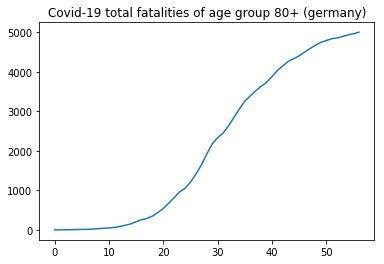

In [4]:
todes_fall = df_.groupby([df_['Meldedatum'].dt.date])['AnzahlTodesfall'].sum()
print(todes_fall.values)
# number is smaller than number of days, because some days have no death case
print(len(todes_fall))

# cumulative death cases
data = [sum(todes_fall[0:x:1]) for x in range(len(todes_fall)+1)][1:]
plt.title("Covid-19 total fatalities of age group 80+ (germany)")
plt.plot(data) 

# initialize part of the parameters

In [5]:
# inital probabilities 
prob_I_to_C = 0.14
min_prob_I_to_C = 0.01
max_prob_I_to_C = 0.5

prob_C_to_Death = 0.95
min_prob_C_to_Death = 0.8 
max_prob_C_to_Death = 1

# the number of actual available ICU beds (canot find the data of 2020-03-01)
# source https://www.intensivregister.de/#/intensivregister
beds_ger = 32585 

# based on https://raw.githubusercontent.com/hf2000510/infectious_disease_modelling/master/data/agegroups.csv
N_80 = 5856000
N_ger = 83765000 

# the number of available ICU beds per 100,000 people
beds_per_100k = int(beds_ger / N_ger * 100000)


## Plotting

In [6]:
plt.gcf().subplots_adjust(bottom=0.15)

def plotter(t, S, E, I, C, R, D, R_0, B, S_1=None, S_2=None, x_ticks=None):
    if S_1 is not None and S_2 is not None:
      print(f"percentage going to ICU: {S_1*100}; percentage dying in ICU: {S_2 * 100}")


    f, ax = plt.subplots(1,1,figsize=(10, 2))
    if x_ticks is None:
        ax.plot(t, S, 'b', alpha=0.7, linewidth=2, label='Susceptible')
        ax.plot(t, E, 'y', alpha=0.7, linewidth=2, label='Exposed')
        ax.plot(t, I, 'r', alpha=0.7, linewidth=2, label='Infected')
        ax.plot(t, C, 'r--', alpha=0.7, linewidth=2, label='Critical')
        ax.plot(t, R, 'g', alpha=0.7, linewidth=2, label='Recovered')
        ax.plot(t, D, 'k', alpha=0.7, linewidth=2, label='Dead')
    else:
        ax.plot(x_ticks, S, 'b', alpha=0.7, linewidth=2, label='Susceptible')
        ax.plot(x_ticks, E, 'y', alpha=0.7, linewidth=2, label='Exposed')
        ax.plot(x_ticks, I, 'r', alpha=0.7, linewidth=2, label='Infected')
        ax.plot(x_ticks, C, 'r--', alpha=0.7, linewidth=2, label='Critical')
        ax.plot(x_ticks, R, 'g', alpha=0.7, linewidth=2, label='Recovered')
        ax.plot(x_ticks, D, 'k', alpha=0.7, linewidth=2, label='Dead')

        ax.xaxis.set_major_locator(mdates.YearLocator())
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
        ax.xaxis.set_minor_locator(mdates.MonthLocator())
        f.autofmt_xdate()


    ax.title.set_text('extended SEIR-Model')

    ax.grid(b=True, which='major', c='w', lw=2, ls='-')
    legend = ax.legend()
    legend.get_frame().set_alpha(0.5)
    for spine in ('top', 'right', 'bottom', 'left'):
        ax.spines[spine].set_visible(False)

    plt.show();
    
    f = plt.figure(figsize=(10,2))
    # sp1
    ax1 = f.add_subplot(131)
    if x_ticks is None:
        ax1.plot(t, R_0, 'b--', alpha=0.7, linewidth=2, label='R_0')
    else:
        ax1.plot(x_ticks, R_0, 'b--', alpha=0.7, linewidth=2, label='R_0')
        ax1.xaxis.set_major_locator(mdates.YearLocator())
        ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
        ax1.xaxis.set_minor_locator(mdates.MonthLocator())
        f.autofmt_xdate()

 
    ax1.title.set_text('R_0 over time')
    ax1.grid(b=True, which='major', c='w', lw=2, ls='-')
    legend = ax1.legend()
    legend.get_frame().set_alpha(0.5)
    for spine in ('top', 'right', 'bottom', 'left'):
        ax.spines[spine].set_visible(False)
    
    # sp2
    ax2 = f.add_subplot(132)
    total_CFR = [0] + [100 * D[i] / sum(sigma*E[:i]) if sum(sigma*E[:i])>0 else 0 for i in range(1, len(t))]
    daily_CFR = [0] + [100 * ((D[i]-D[i-1]) / ((R[i]-R[i-1]) + (D[i]-D[i-1]))) if max((R[i]-R[i-1]), (D[i]-D[i-1]))>10 else 0 for i in range(1, len(t))]
    if x_ticks is None:
        ax2.plot(t, total_CFR, 'r--', alpha=0.7, linewidth=2, label='total')
        ax2.plot(t, daily_CFR, 'b--', alpha=0.7, linewidth=2, label='daily')
    else:
        ax2.plot(x_ticks, total_CFR, 'r--', alpha=0.7, linewidth=2, label='total')
        ax2.plot(x_ticks, daily_CFR, 'b--', alpha=0.7, linewidth=2, label='daily')
        ax2.xaxis.set_major_locator(mdates.YearLocator())
        ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
        ax2.xaxis.set_minor_locator(mdates.MonthLocator())
        f.autofmt_xdate()

    ax2.title.set_text('Fatality Rate (%)')
    ax2.grid(b=True, which='major', c='w', lw=2, ls='-')
    legend = ax2.legend()
    legend.get_frame().set_alpha(0.5)
    for spine in ('top', 'right', 'bottom', 'left'):
        ax.spines[spine].set_visible(False)

    # sp3
    ax3 = f.add_subplot(133)
    newDs = [0] + [D[i]-D[i-1] for i in range(1, len(t))]
    if x_ticks is None:
        ax3.plot(t, newDs, 'r--', alpha=0.7, linewidth=2, label='total')
        ax3.plot(t, [max(0, C[i]-B(i)) for i in range(len(t))], 'b--', alpha=0.7, linewidth=2, label="over capacity")
    else:
        ax3.plot(x_ticks, newDs, 'r--', alpha=0.7, linewidth=2, label='total')
        ax3.plot(x_ticks, [max(0, C[i]-B(i)) for i in range(len(t))], 'b--', alpha=0.7, linewidth=2, label="over capacity")
        ax3.xaxis.set_major_locator(mdates.YearLocator())
        ax3.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
        ax3.xaxis.set_minor_locator(mdates.MonthLocator())
        f.autofmt_xdate()

    ax3.title.set_text('Deaths per day')
    ax3.yaxis.set_tick_params(length=0)
    ax3.xaxis.set_tick_params(length=0)
    ax3.grid(b=True, which='major', c='w', lw=2, ls='-')
    legend = ax3.legend()
    legend.get_frame().set_alpha(0.5)
    for spine in ('top', 'right', 'bottom', 'left'):
        ax.spines[spine].set_visible(False)

    plt.show();

<Figure size 432x288 with 0 Axes>

# Model

In [7]:
def deriv(y, t, beta, gamma, sigma, N, p_I_to_C, p_C_to_D, Beds):
    S, E, I, C, R, D = y

    dSdt = -beta(t) * I * S / N
    dEdt = beta(t) * I * S / N - sigma * E
    dIdt = sigma * E - 1/12.0 * p_I_to_C * I - gamma * (1 - p_I_to_C) * I
    dCdt = 1/12.0 * p_I_to_C * I - 1/7.5 * p_C_to_D * min(Beds(t), C) - max(0, C-Beds(t)) - (1 - p_C_to_D) * 1/6.5 * min(Beds(t), C)
    dRdt = gamma * (1 - p_I_to_C) * I + (1 - p_C_to_D) * 1/6.5 * min(Beds(t), C)
    dDdt = 1/7.5 * p_C_to_D * min(Beds(t), C) + max(0, C-Beds(t))
    return dSdt, dEdt, dIdt, dCdt, dRdt, dDdt

In [15]:
# since it is more diffcult for the aged to recover, gamma is set to the half
gamma = 1.0/18.0
# the incubation period is maybe shorter, set it to 2 
sigma = 1.0/2.0

def logistic_R_0(t, R_0_start, k, x0, R_0_end):
    return (R_0_start-R_0_end) / (1 + np.exp(-k*(-t+x0))) + R_0_end

def Model(days, agegroups, beds_per_100k, R_0_start, k, x0, R_0_end, prob_I_to_C, prob_C_to_D, s):

    def beta(t):
        return logistic_R_0(t, R_0_start, k, x0, R_0_end) * gamma

    N = sum(agegroups)
    
    def Beds(t):
        beds_0 = beds_per_100k / 100_000 * N
        return beds_0 + s*beds_0*t  # 0.003
 
    # five initial infected
    y0 = N-5.0, 5.0, 0.0, 0.0, 0.0, 0.0
    t = np.linspace(0, days-1, days)
    ret = odeint(deriv, y0, t, args=(beta, gamma, sigma, N, prob_I_to_C, prob_C_to_D, Beds))
    S, E, I, C, R, D = ret.T
    R_0_over_time = [beta(i)/gamma for i in range(len(t))]

    return t, S, E, I, C, R, D, R_0_over_time, Beds, prob_I_to_C, prob_C_to_D

# Fitting

In [9]:
# parameters
agegroups = [N_80]

# first case 27.01
outbreak_shift = 30
params_init_min_max = {"R_0_start": (3.0, 2.0, 5.0), "k": (2.5, 0.01, 5.0), "x0": (90, 0, 120), "R_0_end": (0.9, 0.3, 3.5),
                       "prob_I_to_C": (prob_I_to_C, min_prob_I_to_C, max_prob_I_to_C), "prob_C_to_D": (prob_C_to_Death, min_prob_C_to_Death, max_prob_C_to_Death),
                       "s": (0.003, 0.001, 0.01)}  # form: {parameter: (initial guess, minimum value, max value)}

In [10]:
days = outbreak_shift + len(data)

if outbreak_shift >= 0:
    y_data = np.concatenate((np.zeros(outbreak_shift), data))
else:
    y_data = y_data[-outbreak_shift:]

x_data = np.linspace(0, days - 1, days, dtype=int)  # x_data is just [0, 1, ..., max_days] array

def fitter(x, R_0_start, k, x0, R_0_end, prob_I_to_C, prob_C_to_D, s):
    ret = Model(days, agegroups, beds_per_100k, R_0_start, k, x0, R_0_end, prob_I_to_C, prob_C_to_D, s)
    return ret[6][x]

In [11]:
mod = lmfit.Model(fitter)

for kwarg, (init, mini, maxi) in params_init_min_max.items():
    mod.set_param_hint(str(kwarg), value=init, min=mini, max=maxi, vary=True)
    
params = mod.make_params()
fit_method = "leastsq"

In [16]:
result = mod.fit(y_data, params, method="least_squares", x=x_data)

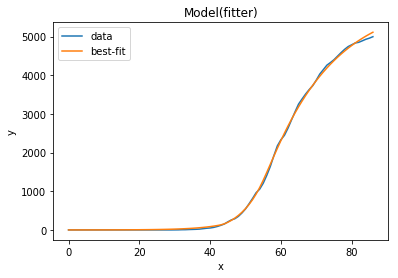

In [17]:
result.plot_fit(datafmt="-");

In [18]:
result.best_values

{'R_0_start': 4.762180626046382,
 'k': 4.9999999984240695,
 'x0': 53.46280329291782,
 'R_0_end': 0.30000000001262433,
 'prob_I_to_C': 0.4999999996328238,
 'prob_C_to_D': 0.800000000000205,
 's': 0.00999999999982863}

Prediction for Age group 80+ of germany
percentage going to ICU: 49.999999963282384; percentage dying in ICU: 80.00000000002049


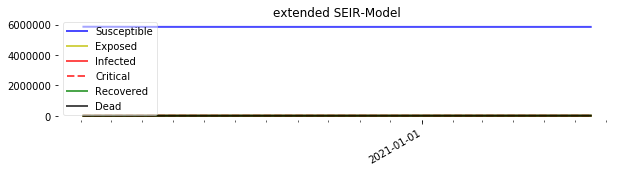

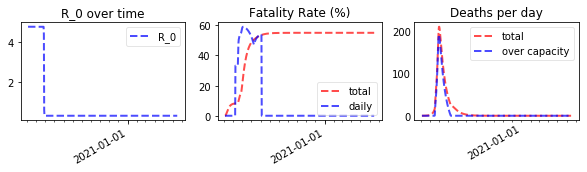

In [19]:
full_days = 500 
first_date = np.datetime64(df_["Meldedatum"].min()) - np.timedelta64(outbreak_shift,'D')
x_ticks = pd.date_range(start=first_date, periods=full_days, freq="D")
print("Prediction for Age group 80+ of germany")
plotter(*Model(full_days, [N_80], beds_per_100k, **result.best_values), x_ticks=x_ticks);

Prediction for Age group 80+ of germany with 10% avaliable ICU beds
percentage going to ICU: 49.999999963282384; percentage dying in ICU: 80.00000000002049


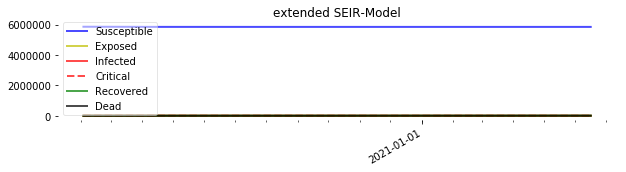

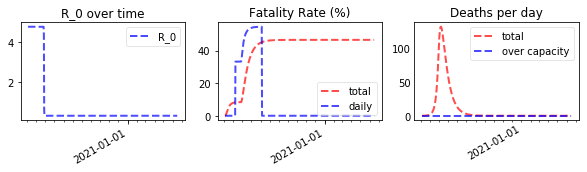

In [21]:
# if there are plenty beds for the aged

full_days = 500 
first_date = np.datetime64(df_["Meldedatum"].min()) - np.timedelta64(outbreak_shift,'D')
x_ticks = pd.date_range(start=first_date, periods=full_days, freq="D") 
print("Prediction for Age group 80+ of germany with 10% avaliable ICU beds")
plotter(*Model(full_days, [N_80], 100, **result.best_values), x_ticks=x_ticks);

Prediction for Age group 80+ of germany with 10% avaliable ICU beds
percentage going to ICU: 49.999999963282384; percentage dying in ICU: 80.00000000002049


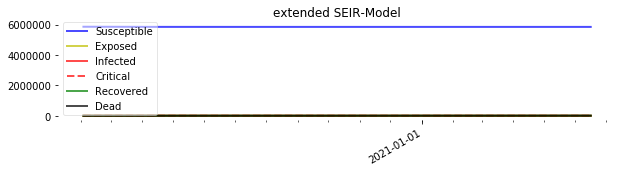

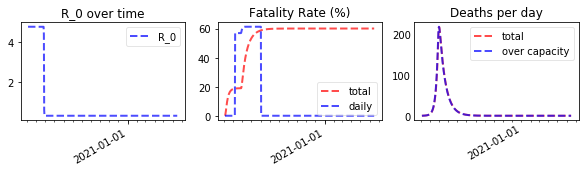

In [22]:
# if there is no avaliable beds for the aged
full_days = 500 
first_date = np.datetime64(df_["Meldedatum"].min()) - np.timedelta64(outbreak_shift,'D')
x_ticks = pd.date_range(start=first_date, periods=full_days, freq="D")
print("Prediction for Age group 80+ of germany with 10% avaliable ICU beds")
plotter(*Model(full_days, [N_80], 0, **result.best_values), x_ticks=x_ticks);